In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import spaces

Train Time Table:
  Train Type Start Planned Arrival Planned Start Actual Arrival Actual
0        ICE         16:03           16:41        16:29          17:07
1      RB 16         16:39           17:41        16:51          17:53
2        ICE         17:25           18:03        18:32          19:10
3      RB 16         17:36           18:34        17:47          18:45
4        ICE         18:03           18:40        18:51          19:28
5        ICE         18:42           19:41        18:44          19:43
6      RB 16         19:07           19:58        19:08          19:59
7      RB 16         20:06           20:45        20:29          21:08
8        ICE         20:09           20:57        20:09          20:57
Delays at Start and Arrival:
   Start Delay  Arrival Delay
0         26.0           26.0
1         12.0           12.0
2         67.0           67.0
3         11.0           11.0
4         48.0           48.0
5          2.0            2.0
6          1.0            1.0
7  

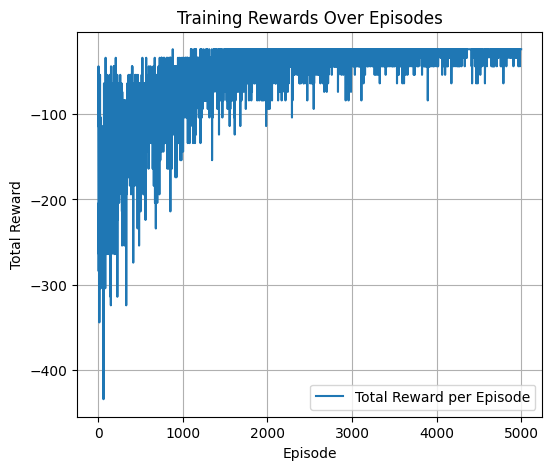

Learned Q-Table:
[[[-33.40156853 -20.1415437 ]
  [-21.77925459 -20.47257093]]

 [[-29.52622086 -10.0880528 ]
  [-20.69226411 -10.49289126]]

 [[-25.19948019 -10.32230182]
  [-30.99405424 -10.24625704]]

 [[-31.2896215  -18.10074284]
  [-28.49081273 -16.4653699 ]]

 [[-19.4630353  -15.55493216]
  [-17.33018871 -15.75826136]]

 [[-11.82201958  -7.11881589]
  [-10.04907511  -8.14955917]]

 [[ -6.82409785  -2.50738053]
  [ -5.49119     -3.55150059]]

 [[  0.           0.        ]
  [  0.           0.        ]]

 [[ -0.7354184    0.        ]
  [  0.          -0.37469307]]

 [[-34.02401399 -25.19632744]
  [-46.60549844 -21.62556487]]

 [[  0.           0.        ]
  [  0.           0.        ]]

 [[-28.37555133  -8.90885311]
  [-19.31029512  -9.13502822]]

 [[-23.81671947  -8.89515242]
  [-22.12483223  -8.44416198]]

 [[-30.5007563  -12.35120639]
  [-24.79975746  -9.1145812 ]]

 [[-23.94783482 -17.3781052 ]
  [-17.29327863 -11.84925273]]

 [[-15.67979186 -12.16587887]
  [ -9.94916018  -8.402

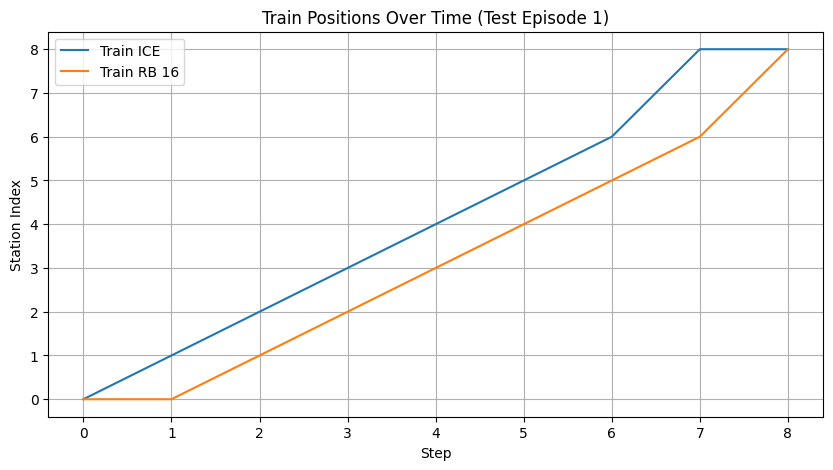

Test Episode 1: Total Reward = -24, Steps = 8

Train Movements (based on Time Table) Documentation:
Train RB 16 starts from Ingolstadt at 16:51
Train RB 16 arrives at Baar-Ebenhausen at 17:00
Train RB 16 arrives at Rohrbach at 17:08
Train RB 16 arrives at Pfaffenhofen at 17:15
Train RB 16 arrives at Reichertshausen at 17:20
Train RB 16 arrives at Paindorf at 17:24
Train RB 16 arrives at Petershausen at 17:28
Train RB 16 arrives at Dachau at 17:38
Train RB 16 arrives at Muenchen at 17:50
Train RB 16 starts from Ingolstadt at 17:47
Train RB 16 arrives at Baar-Ebenhausen at 17:56
Train RB 16 arrives at Rohrbach at 18:04
Train RB 16 arrives at Pfaffenhofen at 18:11
Train RB 16 arrives at Reichertshausen at 18:16
Train RB 16 arrives at Paindorf at 18:20
Train RB 16 arrives at Petershausen at 18:24
Train RB 16 arrives at Dachau at 18:34
Train RB 16 arrives at Muenchen at 18:46
Train RB 16 starts from Ingolstadt at 19:08
Train RB 16 arrives at Baar-Ebenhausen at 19:17
Train RB 16 arrives at R

In [2]:
# Create the DataFrame with the given data
data = {
    'Train Type': ['ICE', 'RB 16', 'ICE', 'RB 16', 'ICE', 'ICE', 'RB 16', 'RB 16', 'ICE'],
    'Start Planned': ['16:03', '16:39', '17:25', '17:36', '18:03', '18:42', '19:07', '20:06', '20:09'],
    'Arrival Planned': ['16:41', '17:41', '18:03', '18:34', '18:40', '19:41', '19:58', '20:45', '20:57'],
    'Start Actual': ['16:29', '16:51', '18:32', '17:47', '18:51', '18:44', '19:08', '20:29', '20:09'],
    'Arrival Actual': ['17:07', '17:53', '19:10', '18:45', '19:28', '19:43', '19:59', '21:08', '20:57']
}

df = pd.DataFrame(data)

print("Train Time Table:")
print(df)

# Convert time columns to datetime format
df['Start Planned'] = pd.to_datetime(df['Start Planned'], format='%H:%M')
df['Arrival Planned'] = pd.to_datetime(df['Arrival Planned'], format='%H:%M')
df['Start Actual'] = pd.to_datetime(df['Start Actual'], format='%H:%M')
df['Arrival Actual'] = pd.to_datetime(df['Arrival Actual'], format='%H:%M')

# Calculate delay in minutes for start and arrival
df['Start Delay'] = (df['Start Actual'] - df['Start Planned']).dt.total_seconds() / 60
df['Arrival Delay'] = (df['Arrival Actual'] - df['Arrival Planned']).dt.total_seconds() / 60

# Display the delay times
print("Delays at Start and Arrival:")
print(df[['Start Delay', 'Arrival Delay']])

# Custom Environment for train scheduling and delays
class TrainEnvironment(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(TrainEnvironment, self).__init__()
        self.df = df
        self.stations = ['Ingolstadt', 'Baar-Ebenhausen', 'Rohrbach', 'Pfaffenhofen', 'Reichertshausen', 'Paindorf', 'Petershausen', 'Dachau', 'Muenchen']  # List of station names
        self.train_types = ['RB 16', 'ICE']  # Types of trains
        self.num_train_types = 2  # Number of trains
        self.train_positions = np.zeros(self.num_train_types, dtype=int)  # Initial positions of trains (all at the first station)
        self.train_delays = np.zeros(self.num_train_types, dtype=int)  # Initial delays of trains
        
        self.block_sections = { # Consecutive stations (= block sections)
            'Ingolstadt-Baar-Ebenhausen', 'Baar-Ebenhausen-Rohrbach', 'Rohrbach-Pfaffenhofen',
            'Pfaffenhofen-Reichertshausen', 'Reichertshausen-Paindorf', 'Paindorf-Petershausen',
            'Petershausen-Dachau', 'Dachau-Muenchen'
        }
        self.num_block_sections = len(self.block_sections)
        self.block_distances = { # Distances in km between consecutive stations (between block sections)
            'Ingolstadt-Baar-Ebenhausen': 9.5, 'Baar-Ebenhausen-Rohrbach': 14, 'Rohrbach-Pfaffenhofen': 11.5,
            'Pfaffenhofen-Reichertshausen': 5.9, 'Reichertshausen-Paindorf': 3.5, 'Paindorf-Petershausen': 3.5,
            'Petershausen-Dachau': 18, 'Dachau-Muenchen': 20
        }
        self.block_time = { # Time in minutes of each train to pass/reach the next station from self.stations
            'RB 16': [9, 8, 7, 5, 4, 4, 10, 12],
            'ICE': [6, 5, 5, 3, 3, 3, 6, 8]
        }

        # Define the stations each train type plans to stop at to let people enter the train
        self.stopping_stations = {
            'RB 16': self.stations,  # Stops at all stations
            'ICE': ['Ingolstadt', 'Muenchen']  # Only stops at start and end
        }

        self.action_space = spaces.MultiDiscrete([2] * self.num_train_types)  # MultiDiscrete space indicating whether each train should move (1) or not (0)
        self.observation_space = spaces.Discrete(len(self.stations) ** self.num_train_types)  # Discrete space representing all possible states of the trains' positions

    # Reset the environment to the initial state
    def reset(self):
        self.train_positions = np.zeros(self.num_train_types, dtype=int)
        
        # Initialize train times from the timetable
        self.train_times = {
            'RB 16': [],
            'ICE': []
        }

        for train_type in self.train_types:
            train_rows = self.df[self.df['Train Type'] == train_type]
            for _, row in train_rows.iterrows():
                planned_time = pd.to_datetime(row['Start Planned'], format='%H:%M')
                start_delay = pd.to_timedelta(row['Start Delay'], unit='m')
                actual_start_time = planned_time + start_delay
                self.train_times[train_type].append(actual_start_time)

        return self.get_state_index()

    # Calculate the state index based on train positions
    def get_state_index(self):
        return int(np.dot(self.train_positions, [len(self.stations) ** i for i in range(self.num_train_types)]))

    # Execute the given actions and update the state
    def step(self, actions):
        done = False
        reward = 0
        next_positions = np.copy(self.train_positions)

        for i in range(self.num_train_types):
            if self.train_positions[i] < len(self.stations) - 1:
                current_station = self.stations[self.train_positions[i]]
                next_station = self.stations[self.train_positions[i] + 1]
                distance_key = current_station + '-' + next_station

                if distance_key in self.block_distances:
                    expected_time = self.block_time[self.df['Train Type'].iloc[i]][self.train_positions[i]]
                    actual_time = 1  # 1 minute to move to the next station

                    if actions[i] == 1:
                        if next_positions[i] + 1 not in next_positions:  # Ensure no two trains on the same track
                            next_positions[i] += 1
                            self.train_positions[i] = next_positions[i]
                            delay = (actual_time - expected_time)
                            self.train_delays[i] += delay
                            reward += self.calculate_delay_penalty(delay)
                        else:
                            reward -= 10  # Penalize if trying to move to an occupied position
                    elif actions[i] == 0:
                        reward -= 10  # Small penalty for not moving

        if all(pos >= len(self.stations) - 2 for pos in self.train_positions):
            done = True

        for i in range(self.num_train_types):
            if self.train_positions[i] == len(self.stations) - 2:
                self.train_positions[i] = len(self.stations) - 1  # Remove train from the system by setting its position to a non-track state

        return self.get_state_index(), reward, done, {}

    # Calculate delay penalty
    def calculate_delay_penalty(self, delay):
        if delay <= 5:
            return -1
        elif delay <= 10:
            return -2
        elif delay <= 15:
            return -3
        elif delay <= 20:
            return -4
        elif delay <= 25:
            return -5
        elif delay <= 30:
            return -6
        elif delay <= 35:
            return -7
        elif delay <= 40:
            return -8
        elif delay <= 45:
            return -9
        elif delay <= 50:
            return -10
        elif delay <= 55:
            return -11
        elif delay <= 60:
            return -12
        elif delay <= 70:
            return -13
        elif delay <= 80:
            return -14
        elif delay <= 90:
            return -15
        else:
            return -20
    
    # Display delay penalties based on the delay times
    def display_delay_penalties(self):
        penalties = {'Train Type': [], 'Start Delay (min)': [], 'Arrival Delay (min)': [], 'Penalty': []}
        for _, row in self.df.iterrows():
            start_delay = row['Start Delay']
            arrival_delay = row['Arrival Delay']
            penalty = self.calculate_delay_penalty(start_delay) + self.calculate_delay_penalty(arrival_delay)
            penalties['Train Type'].append(row['Train Type'])
            penalties['Start Delay (min)'].append(start_delay)
            penalties['Arrival Delay (min)'].append(arrival_delay)
            penalties['Penalty'].append(penalty)
        
        penalty_df = pd.DataFrame(penalties)
        print(penalty_df)
        return penalty_df

    # Render the environment (display train positions)
    def render(self, mode='human'):
        print("Train Positions:", self.train_positions)


# Q-learning algorithm for training the agent
def q_learning(env, episodes, alpha, gamma, epsilon_start, epsilon_end, epsilon_decay):
    num_states = env.observation_space.n
    num_actions = env.action_space.nvec[0]
    q_table = np.zeros((num_states, env.num_train_types, num_actions))
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        # Update epsilon for the current episode
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-epsilon_decay * episode)

        while not done:
            actions = []
            for i in range(env.num_train_types):
                if np.random.rand() < epsilon:
                    action = np.random.randint(num_actions)
                else:
                    action = np.argmax(q_table[state, i])
                actions.append(action)

            new_state, reward, done, _ = env.step(actions)
            total_reward += reward

            for i in range(env.num_train_types):
                old_value = q_table[state, i, actions[i]]
                next_max = np.max(q_table[new_state, i])
                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                q_table[state, i, actions[i]] = new_value

            state = new_state

        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {epsilon}")

    # Plotting the training rewards over episodes
    plt.figure(figsize=(6, 5))
    plt.plot(range(1, episodes + 1), episode_rewards, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards Over Episodes')
    plt.legend()
    plt.grid()
    plt.show()

    return q_table


# Test the trained agent
def test_agent(env, q_table, episodes):
    num_actions = env.action_space.nvec[0] if isinstance(env.action_space, spaces.MultiDiscrete) else env.action_space.n

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        train_positions_over_time = []

        # Record the initial positions before taking any actions
        train_positions_over_time.append(list(env.train_positions))  # Record initial train positions

        while not done:
            actions = []
            for i in range(env.num_train_types):
                action = np.argmax(q_table[state, i])
                actions.append(action)

            print(f"Episode {episode + 1}, Step {steps + 1}, Actions: {actions}")
            new_state, reward, done, _ = env.step(actions)
            total_reward += reward
            state = new_state
            steps += 1

            train_positions_over_time.append(list(env.train_positions))

        train_positions_over_time = np.array(train_positions_over_time)

        plt.figure(figsize=(10, 5))
        for i in range(env.num_train_types):
            plt.plot(train_positions_over_time[:, i], label=f'Train {env.df["Train Type"].iloc[i]}')
        plt.xlabel('Step')
        plt.ylabel('Station Index')
        plt.title(f'Train Positions Over Time (Test Episode {episode + 1})')
        plt.legend()
        plt.grid()
        plt.show()

        print(f"Test Episode {episode + 1}: Total Reward = {total_reward}, Steps = {steps}")

# Example Usage
alpha = 0.1
gamma = 0.9
epsilon_start = 1.0  # Start with full exploration
epsilon_end = 0.01  # End with minimal exploration
epsilon_decay = 0.001  # Control how fast epsilon decays
training_episodes = 5000
testing_episodes = 1

env = TrainEnvironment(df)

# Display delay penalties
penalty_df = env.display_delay_penalties()

# Q-learning with dynamic epsilon
q_table = q_learning(env, training_episodes, alpha, gamma, epsilon_start, epsilon_end, epsilon_decay)
print("Learned Q-Table:")
print(q_table)

# Testing the agent
test_agent(env, q_table, testing_episodes)

# Documentation of train movements based on Information from the Time Table
print("\nTrain Movements (based on Time Table) Documentation:")
for train_type in env.train_types:
    for i, start_time in enumerate(env.train_times[train_type]):
        print(f"Train {train_type} starts from Ingolstadt at {start_time.strftime('%H:%M')}")
        for j, station in enumerate(env.stations[1:], start=1):
            time_at_station = start_time + pd.to_timedelta(sum(env.block_time[train_type][:j]), unit='m')
            print(f"Train {train_type} arrives at {station} at {time_at_station.strftime('%H:%M')}")

# Documentation of delays and penalties
print("\nDelays and Penalties Documentation:")
for train_type in env.train_types:
    for i, start_time in enumerate(env.train_times[train_type]):
        delay_at_start = df[(df['Train Type'] == train_type) & (df['Start Actual'] == start_time)]['Start Delay'].values[0]
        penalty_at_start = env.calculate_delay_penalty(delay_at_start)
        print(f"Train {train_type} has a delay of {delay_at_start} minutes at Ingolstadt and gets a penalty of {penalty_at_start}.")
        for j, station in enumerate(env.stations[1:], start=1):
            planned_time = start_time + pd.to_timedelta(sum(env.block_time[train_type][:j]), unit='m')
            actual_time = df[(df['Train Type'] == train_type) & (df['Start Actual'] == start_time)]['Arrival Actual'].values[0]
            delay_at_station = (actual_time - planned_time).total_seconds() / 60
            penalty_at_station = env.calculate_delay_penalty(delay_at_station)
            print(f"Train {train_type} has a delay of {delay_at_station} minutes at {station} and gets a penalty of {penalty_at_station}.")

# Display the delay penalties
print("Delay Penalties:")
delay_penalties_df = env.display_delay_penalties()
print(delay_penalties_df)